In [1]:
from keras.applications import VGG16

conv_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)

conv_base.summary()

/home/n/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [3]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '../../Downloads/all/cats_and_dogs_small/'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary'
    )
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

# need to flatten for classifier

train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [4]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(
    optimizer=optimizers.RMSprop(lr=2e-5),
    loss='binary_crossentropy',
    metrics=['acc']
)

In [ ]:
history = model.fit(
    train_features,
    train_labels,
    epochs=30,
    batch_size=20,
    validation_data=(validation_features, validation_labels)
)

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Instead of simply using the pretrained convnet and only running data through our classifier at the end (above), we can instead pass our data through the entire pretrained network and our classifier (below). This gives us the chance to exploit feature augmentation to reduce overfitting. It is far more computationally expensive however.

We can just use an entire trained convnet as a layer in our model(!).

In [11]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


We need to take care to freeze the pretrained convnet so we don't pollute it with our random starting weights. And also compile the model once we've made these changes.

In [10]:
conv_base.trainable = False

model.compile(
    optimizer=optimizers.RMSprop(lr=2e-5),
    loss='binary_crossentropy',
    metrics=['acc']
)

Now we can augment our training data.

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Remember: steps_per_epoch/validation_steps are based on multiplying the batch_size (in generator) with steps, to get the total. So we have 2000 training items, and 1000 test items (20 * 100 and 20 * 50 respectively).

In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

To get higher accuracy we can freeze only some blocks within the pretrained convnet. The deeper (earlier) layers in the network are more general and thus probably more useful to our situation, so we only want to freeze higher (later) layers where they get more specific to their training data (instead of ours). 

In [12]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        

We use a lower learning rate here so our data doesn't make too big of an impact on the final layers we're tweaking. They're already ok, we just want to give them a little influence from our data to improve our results. A large learning rate would skew them too much and make them less useful than untweaked ones.

In [13]:
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=1e-5),
    metrics=['acc']
)

In [14]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50
)

Epoch 1/100
100/100 [==============================] - 16s 157ms/step - loss: 0.5531 - acc: 0.7195 - val_loss: 0.3554 - val_acc: 0.8630
Epoch 2/100
100/100 [==============================] - 15s 150ms/step - loss: 0.3832 - acc: 0.8380 - val_loss: 0.2609 - val_acc: 0.8870
Epoch 3/100
100/100 [==============================] - 15s 148ms/step - loss: 0.3328 - acc: 0.8530 - val_loss: 0.2204 - val_acc: 0.9080
Epoch 4/100
100/100 [==============================] - 14s 144ms/step - loss: 0.2951 - acc: 0.8700 - val_loss: 0.2209 - val_acc: 0.9020
Epoch 5/100
100/100 [==============================] - 15s 146ms/step - loss: 0.2609 - acc: 0.8880 - val_loss: 0.2028 - val_acc: 0.9170
Epoch 6/100
100/100 [==============================] - 15s 146ms/step - loss: 0.2459 - acc: 0.8915 - val_loss: 0.1903 - val_acc: 0.9190
Epoch 7/100
100/100 [==============================] - 15s 148ms/step - loss: 0.2434 - acc: 0.8965 - val_loss: 0.2035 - val_acc: 0.9080
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 15s 149ms/step - loss: 0.0410 - acc: 0.9850 - val_loss: 0.1956 - val_acc: 0.9380
Epoch 62/100
100/100 [==============================] - 15s 149ms/step - loss: 0.0394 - acc: 0.9865 - val_loss: 0.2592 - val_acc: 0.9190
Epoch 63/100
100/100 [==============================] - 15s 152ms/step - loss: 0.0430 - acc: 0.9845 - val_loss: 0.2044 - val_acc: 0.9360
Epoch 64/100
100/100 [==============================] - 15s 149ms/step - loss: 0.0404 - acc: 0.9835 - val_loss: 0.2332 - val_acc: 0.9330
Epoch 65/100
100/100 [==============================] - 15s 149ms/step - loss: 0.0346 - acc: 0.9880 - val_loss: 0.2383 - val_acc: 0.9320
Epoch 66/100
100/100 [==============================] - 15s 148ms/step - loss: 0.0409 - acc: 0.9855 - val_loss: 0.2099 - val_acc: 0.9330
Epoch 67/100
100/100 [==============================] - 15s 149ms/step - loss: 0.0402 - acc: 0.9860 - val_loss: 0.2646 - val_acc: 0.9230
Epoch 68/100
100/100 [===================

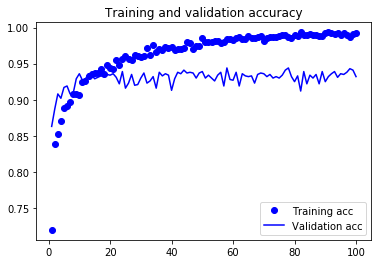

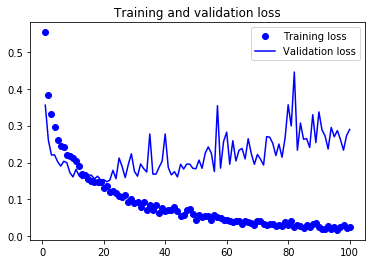

In [17]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [18]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)

print('test accuracy:', test_acc)

Found 1000 images belonging to 2 classes.
('test accuracy:', 0.9379999923706055)
